# Segunda Prova de Pesquisa Operacional (29/09/2023)

## Aluno: Matteus Silvestre Maciel das Neves Carvalho

Resolva os problemas abaixo usando os códigos em `Julia`. Imprima o modelo e a solução, tanto o valor da função objetivo como o valor de cada variável.

# Questão 1

Uma empresa fabricante de bicicletas possui três fábricas localizadas no Rio de Janeiro, em São Paulo, e em Belo Horizonte, A produção da empresa deve ser entregue em Recife, Salvador e
Manaus. A tabela abaixo informa os custos de transporte de casa fábrica para cada centro
consumidor e também a capacidade de produção de cada uma das fábricas e a demanda de
cada centro:

| Fábrica\Centro consumidor | Recife | Salvador | Manaus | Capacidade |
|:---:|:---:|:---:|:---:|:---:|
| Rio de Janeiro | 25 | 20 | 30 | 1800 |
| São Paulo | 30 | x$^*$ | 29 | 1800 |
| Belo Horizonte | 20 | 17 | 23 | 1800 |
| Demanda | 2000 | 2000 | 1000 | - |

\*: A fábrica de São Paulo não entrega ao centro de Salvador

Resolva o Problema como um problema de transporte, de forma a minimizar os custos com transporte das fábricas para os centros consumidores.

*Solução:*

Como a capacidade total é de 5400 bicicletas e a demanda total é de 5000, temos um problema desbalanceado. Então, para expressá-lo como um problema de programação linear será necessário gerar um nó *dummy* que representa um centro consumidor de demanda igual a 400 bicicletas.

In [1]:
# Bibliotecas a serem usadas
using JuMP, GLPK

In [2]:
# Capacidades e demandas
b=[1800, 1800,1800, 2000,2000,1000,400]

# Nós iniciais e finais dos arcos
start_node = [1,1,1,1, 2,2,2, 3,3,3,3]
end_node = [4,5,6,7, 4,6,7, 4,5,6,7]

# Custos dos arcos
c=[25,20,30,50, 30,19,50, 10,17,13,50]

# Arcos
links = Tuple( (start_node[i], end_node[i]) for i in 1:length(end_node) )
c_dict = Dict(links .=> c)
links

((1, 4), (1, 5), (1, 6), (1, 7), (2, 4), (2, 6), (2, 7), (3, 4), (3, 5), (3, 6), (3, 7))

In [ ]:
# Modelo
model = Model(GLPK.Optimizer)

# Variáveis
@variable(model, x[link in links]>=0)

# Função objetivo
@objective(model, Min, sum(c_dict[link] * x[link] for link in links))

# Restrições de capacidade (fábricas)
for i in 1:3
   @constraint(model, sum(x[(ii,j)] for (ii,j) in links if ii==i) == b[i])
end
# Restrições de demandas (centros consumidores)
for j in 4:7
   @constraint(model, sum(x[(i,jj)] for (i,jj) in links if jj==j) == b[j])
end

# Descrição do  modelo
println(model)

In [ ]:
# Otimização do modelo
JuMP.optimize!(model)
obj = JuMP.objective_value(model)

# Custo mínimo
println("Função Objetivo: FO=", obj)

# Fluxo entre fábricas e centros
capac = ["Rio de Janeiro", "São Paulo", "Belo Horizonte"]
deman = ["de Recife", "de Salvador", "de Manaus", "dummy"]
for i in 1:3
    for j in 1:4
        if (i==2 && j==2)
            println("Fábrica de ",capac[i]," e centro ",deman[j],": 0") # x(2,5) não existe           
        else
            println("Fábrica de ",capac[i]," e centro ",deman[j],": ",value(x[(i,j+3)]))
        end
    end
end

# Questão 2

Uma empresa deseja enviar seus produtos em um caminhão que vai partir de seu centro de
distribuição, localizado em 1, para uma cidade localizada em 6. A rede abaixo indica as
possíveis rotas a serem percorridas pelo caminhão. Modele este problema como um
problema de caminho mínimo, de forma que o caminhão percorra a menor distância possível.
Suponha que os nós sejam cidades e que os valores sobre os arcos sejam as distâncias em km
de uma cidade para outra.

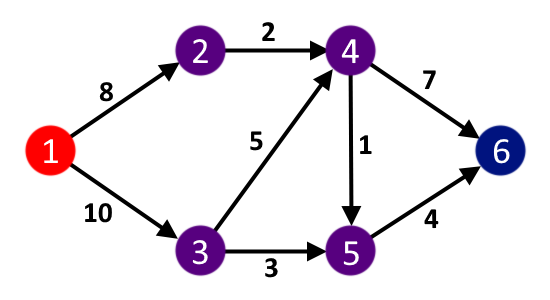

*Solução:*

In [ ]:
# Números e tipos dos nós (-1 para inicial, 0 para intermediário, 1 para final)
nodes = 1:6
b=[-1,0,0,0,0,1]

# Inícios e fins dos 8 arcos
start_node = [1,1, 2, 3,3, 4,4, 5]
end_node = [2,3, 4, 4,5, 5,6, 6]

# Custos associados aos arcos
c=[8,10, 2, 4,3, 1,7, 4]

# Arcos
links = Tuple( (start_node[i], end_node[i]) for i in 1:length(start_node) )
c_dict = Dict(links .=> c)

links

In [ ]:
# Modelo
model = Model(GLPK.Optimizer)

# Variáveis (caminhos)
@variable(model, 0<= x[link in links])

# Função objetivo 
@objective(model, Min, sum(c_dict[link] * x[link] for link in links))

# Custos dos caminhos
for i in nodes
   @constraint(model, -sum(x[(ii,j)] for (ii,j) in links if ii==i)
                   + sum(x[(j,ii)] for (j,ii) in links if ii==i) == b[i])
end

# Descrição do modelo
println(model)

In [ ]:
# Otimização do modelo
JuMP.optimize!(model)
obj = JuMP.objective_value(model)

# Custo mínimo
println("Função Objetivo: FO=", obj)

# Caminho de custo mínimo
for link in links
  println("Valor de x",link," = ",value(x[link]))
end

Ou seja, o caminho ótimo é:

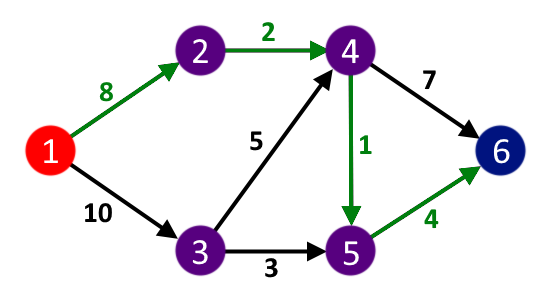

# Questão 3

Uma empresa deseja enviar o máximo fluxo de gás do nó 1 para o nó 6. Os valores sobre
os arcos indicam as capacidades de cada trecho de tubulação. Resolva como um problema de
fluxo máximo.

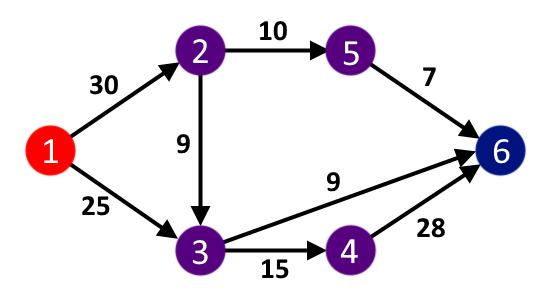

In [ ]:
# Número de nós e arcos
nodes = 1:6

# Inícios e fins dos 9 arcos (8 informados + 1 do final ao inicial)
start_node = [1,1, 2,2, 3,3, 4, 5, 6]
end_node = [2,3, 3,5, 4,6, 6, 6, 1]

# Fluxo máximo de cada arco
c = [20,25, 9,10, 15,9, 28, 7, 100]

# Arcos
links = Tuple( (start_node[i], end_node[i]) for i in 1:9)
c_dict = Dict(links .=> c)
    
links

In [ ]:
# Modelo
model = Model(GLPK.Optimizer)

# Variáveis
@variable(model, 0 <= x[link in links] <= c_dict[link])

# Função objetivo
@objective(model, Max, x[(6,1)])

# Restricões
for i in nodes
   @constraint(model, -sum(x[(ii,j)] for (ii,j) in links if ii==i)
                   + sum(x[(j,ii)] for (j,ii) in links if ii==i) == 0)
end

# Descrição do modelo
println(model)

In [ ]:
# Otimização do modelo
JuMP.optimize!(model)
obj = JuMP.objective_value(model)

# Valor do fluxo máximo
println("Função Objetivo: FO = ", obj)

# Caminho do fluxo máximo
for link in links
  println("Valor de x",link," = ",value(x[link]))
end

Ou seja, a solução ótima é:

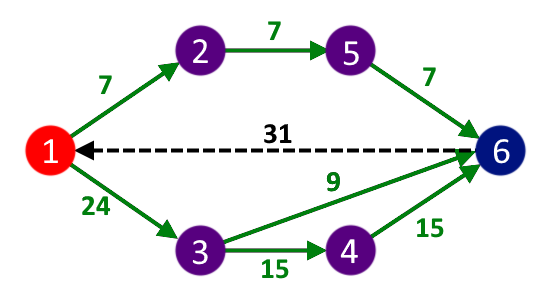

# Questão 4

Três operadores estão qualificados para operar cada uma das 4 máquinas existentes em uma indústria. A tabela a seguir apresenta os custos unitários associados a cada operador e máquina. Resolva o problema de forma a alocar cada operador em uma única máquina e que cada máquina receba somente um operador, de modo a minimizar o custo total.

| Operadores/Máquinas | 1 | 2 | 3 | 4 |
|:---:|:---:|:---:|:---:|:---:|
| Carlos | 40 | 75 | 100 | 80 |
| Antonio | 60 | 62 | 80 | 55 |
| Pedro | 75 | 70 | 120 | 50 |


*Solução:*

Com 3 operadores e 4 máquinas, temos um caso de problema de atribuição desbalanceado. Ou seja, ao expressar a situação como problema de programação linear, as restrições associadas às máquinas serão desigualdades.

In [ ]:
# Início e fim dos arcos
start_node = [1,1,1,1, 2,2,2,2, 3,3,3,3]
end_node = [4,5,6,7, 4,5,6,7, 4,5,6,7]

# Pesos dos arcos
c = [40,75,100,80, 60,62,80,55, 75,70,120,50]

# Arcos
links = Tuple( (start_node[i], end_node[i]) for i in 1:length(end_node) )
c_dict = Dict(links .=> c)
links

In [ ]:
# Modelo
model = Model(GLPK.Optimizer)

# Variáveis
@variable(model, x[link in links]>=0)

# Função objetivo
@objective(model, Min, sum(c_dict[link] * x[link] for link in links))

# Restrições de nós iniciais (operadores)
for i in 1:3
   @constraint(model, sum(x[(ii,j)] for (ii,j) in links if ii==i) == 1)
 end

# Restrições de nós de destino (máquinas)
for j in 4:7
   @constraint(model, sum(x[(i,jj)] for (i,jj) in links if jj==j) <=1)
end

# Descrição do modelo
println(model)

In [ ]:
# Otimização do modelo
optimize!(model)
obj = objective_value(model)

# Custo mínimo
println("Função Objetivo: FO = ", obj)

# Atribuição entre operadores e máquinas
oper = ["Carlos", "Antonio", "Pedro"]
for i in 1:3
    for j in 1:4
        println("Operador ",oper[i]," e máquina ",j,": ",value(x[(i,j+3)]))
    end
end

Ou seja, a atribuição ótima é:

| Operador | Máquina |
|:---:|:---:|
| Carlos | 1  |
| Antonio | 2 |
| Pedro | 4 |

A máquina 3 não será utilizada.